In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization, Embedding, MultiHeadAttention, Dropout, Input, Add,LayerNormalization,Softmax,BatchNormalization
from tensorflow.keras.models import Model, Sequential

import numpy as np

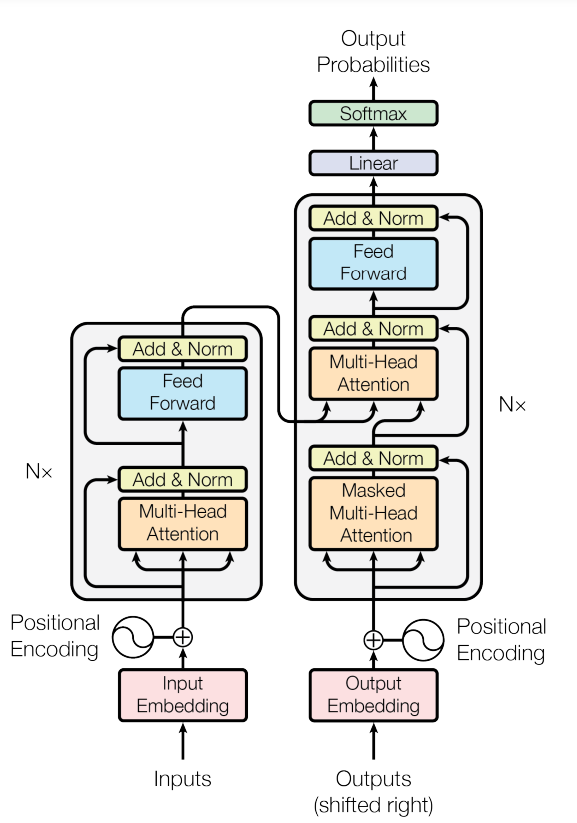

# Positional Encoding

In [2]:
import numpy as np

def positional_encoding(vocab_len, d_model):
    j = np.arange(d_model)
    Encodings = np.zeros((vocab_len, d_model))
    for p in range(vocab_len):
        Encodings[p][0::2] +=  np.sin(p/np.power(10000,2*j[0::2]/d_model))
        Encodings[p][1::2] +=  np.cos(p/np.power(10000,2*j[0::2]/d_model))
    return Encodings

# Multi head Attention layer in the Encoder

In [3]:
def multihead_attention_encoder(x_shape, num_heads = 1):
    # Inputs
    inputs = Input(shape=x_shape)
    # Attention
    attention_layer = MultiHeadAttention(num_heads = num_heads,key_dim=x_shape[-1])(inputs,inputs,inputs)
    # Residual
    residual_layer = Add()([inputs, attention_layer])
    # Normalization
    normalized_output = LayerNormalization()(residual_layer)

    model = Model(inputs = inputs, outputs = normalized_output)
    return model

# Positional Feed-Forawrd

In [4]:
def positional_feed_forward(x_shape, d_ff):
    # x_shape: (sequence_length, d_model)
    inputs = Input(shape=x_shape)
    
    dense1 = Dense(d_ff, activation='relu')(inputs)
    dense2 = Dense(x_shape[-1])(dense1)
    # Residual
    residual_layer = Add()([inputs, dense2])
    # Normalization
    normalized_output = BatchNormalization()(residual_layer)
    
    model = Model(inputs=inputs, outputs=normalized_output)
    return model

# Masked multi head Attention layer

In [5]:
def create_causal_mask(length):
    # Creates a lower triangular matrix with ones (1s) and zeros (0s)
    mask = np.tril(np.ones((length, length)))
    return tf.constant(mask, dtype=tf.float32)

def masked_multihead_attention(x_shape, num_heads = 1):
    # Inputs
    inputs = Input(shape=x_shape)
    # Masked Attention
    attention_layer = MultiHeadAttention(num_heads = num_heads,key_dim=x_shape[-1])(
            inputs,inputs,inputs, attention_mask = create_causal_mask(x_shape[-2])
        )
    # Residual
    residual_layer = Add()([inputs, attention_layer])
    # Normalization
    normalized_output = LayerNormalization()(residual_layer)
    
    model = Model(inputs = inputs, outputs = normalized_output)
    return model

# Multi head Attention in the decoder

In [6]:
def multihead_attention_decoder(x_shape, num_heads = 1):
    # Inputs
    query = Input(shape=x_shape, name = "query")
    key = Input(shape=x_shape, name = "key")
    value = Input(shape=x_shape, name = "key")
    # Attention
    bra = MultiHeadAttention(num_heads = num_heads,key_dim=x_shape[-1], name = "testing_attention")
    attention_layer = bra(
            query,key,value
        )
    # Residual
    residual_layer = Add()([query, attention_layer])
    # Normalization
    normalized_output = LayerNormalization()(residual_layer)
    
    model = Model(inputs = [query,key_value,key_value], outputs = normalized_output)
    return model

# Output layer Linear-Softmax

In [7]:
def output_layer(y_shape):

    decoder_outputs = Input(shape=y_shape)
    
    logits = Dense(y_shape[-1])(decoder_outputs)
    
    # Softmax
    probabilities = Softmax(axis=-1)(logits)
    
    model = Model(inputs=decoder_outputs, outputs=probabilities)
    return model

In [8]:
def encoder(x_shape,num_heads,d_ff):
    inputs = Input(shape=x_shape)
    attention_encoder = multihead_attention_encoder(x_shape,num_heads)(inputs)
    feed_forward_encoder = positional_feed_forward(x_shape,d_ff)(attention_encoder)
    model = Model(inputs=inputs, outputs=feed_forward_encoder)
    return model

def decoder(x_shape,y_shape,num_heads,d_ff):
    q = Input(shape=y_shape)
    k = Input(shape=x_shape)
    v = Input(shape=x_shape)
    # Decoder
    masked_attention_decoder = masked_multihead_attention(y_shape,num_heads)(q)
    attention_layer = MultiHeadAttention(num_heads = num_heads,key_dim=y_shape[-1], name = "testing_attention")(
        query = masked_attention_decoder,
        key = k,
        value = v
        )
    # Residual
    residual_layer = Add()([masked_attention_decoder, attention_layer])
    # Normalization
    normalized_output = LayerNormalization()(residual_layer)
    
    feed_forward_decoder = positional_feed_forward(y_shape,d_ff)(normalized_output)
    model = Model(inputs=[q,k,v], outputs=feed_forward_decoder)
    return model

# Transformer, TaDa !

In [9]:
def transformer(x_shape,y_shape,num_heads,d_ff):
    # Encoder
    inputs_1 = Input(shape=x_shape)
    inputs_2 = Input(shape=y_shape)
    encoder_model = encoder(x_shape,num_heads,d_ff)(inputs_1)
    
    # Decoder

    masked_attention_decoder = masked_multihead_attention(y_shape,num_heads)(inputs_2)
    attention_layer = MultiHeadAttention(num_heads = num_heads,key_dim=y_shape[-1], name = "testing_attention")(
        query = masked_attention_decoder,
        key = encoder_model,
        value = encoder_model
        )
    # Residual
    residual_layer = Add()([masked_attention_decoder, attention_layer])
    # Normalization
    normalized_output = LayerNormalization()(residual_layer)
    
    feed_forward_decoder = positional_feed_forward(y_shape,d_ff)(normalized_output)
    # Output
    outputs = output_layer(y_shape)(feed_forward_decoder)
    
    model = Model(inputs=[inputs_1,inputs_2], outputs=outputs)
    return model

### Testing multi head attention and postitional encoding

In [10]:
np.random.seed(42)
test_words  = np.random.rand(1,10, 4)

test_words = test_words+positional_encoding(test_words.shape[1],test_words.shape[2])
# test_words = test_words.reshape((1,1, test_words.shape[0], test_words.shape[1]))

model = transformer(test_words.shape[1:],test_words.shape[1:],10,1000)

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
model.predict([test_words,test_words])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


array([[[0.4379995 , 0.17911416, 0.26330978, 0.11957655],
        [0.40742853, 0.28076813, 0.2559201 , 0.05588318],
        [0.37326008, 0.32545632, 0.24816677, 0.05311682],
        [0.38439184, 0.26870427, 0.21191025, 0.13499369],
        [0.44411924, 0.13638069, 0.1902131 , 0.2292869 ],
        [0.45571348, 0.14956662, 0.21959308, 0.1751267 ],
        [0.40365282, 0.1956216 , 0.29161537, 0.10911021],
        [0.3735779 , 0.3212284 , 0.26044855, 0.04474512],
        [0.45882934, 0.19474326, 0.21873088, 0.12769651],
        [0.3893257 , 0.19111629, 0.18251994, 0.23703806]]], dtype=float32)

In [11]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 10, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 10, 4)     │        772 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 10, 4)     │      9,792 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ testing_attention   │ (None, 10, 4)     │        764 │ functional_2[0][… │
│ (MultiHeadAttentio… │                   │            │ functional_3[0][… │
│                     │                   │            │ functional_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 4)     │          0 │ functional_3[0][… │
│                     │                   │            │ testing_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 4)     │          8 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 10, 4)     │      9,020 │ layer_normalizat… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 10, 4)     │         20 │ functional_4[0][… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,376 (79.59 KB)

 Trainable params: 20,360 (79.53 KB)

 Non-trainable params: 16 (64.00 B)

In [12]:
from models import Transformer

In [13]:
np.random.seed(42)
test_words  = np.random.rand(1,10, 4)

test_words = test_words+positional_encoding(test_words.shape[1],test_words.shape[2])
# test_words = test_words.reshape((1,1, test_words.shape[0], test_words.shape[1]))

model = Transformer(test_words.shape[1:],test_words.shape[1:],10,1000)
model = model.transformer()

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
model.predict([test_words,test_words])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


array([[[0.03368514, 0.41186187, 0.22774516, 0.32670778],
        [0.03252041, 0.32702652, 0.19544062, 0.4450124 ],
        [0.04301751, 0.30607238, 0.19924432, 0.45166585],
        [0.05739307, 0.30311027, 0.1811768 , 0.45831996],
        [0.02386524, 0.40052176, 0.14581865, 0.42979428],
        [0.01797329, 0.40817192, 0.15560599, 0.41824883],
        [0.02694313, 0.40604055, 0.21568117, 0.35133514],
        [0.07626912, 0.26708207, 0.22869563, 0.42795318],
        [0.03036742, 0.34399474, 0.16472636, 0.4609115 ],
        [0.05817235, 0.32943803, 0.16208099, 0.4503086 ]]], dtype=float32)